In most data science tutorials I have seen, a lot of the data clean-up is done in what seems to me casually, an annoying obstacle to get to the sexy Machine Learning bit. I was curious to see what if any difference it made in my Kaggle ranking if I used a somewhat more cautious approach in my data cleanup. My approach was to dumbly follow [Datacamp's tutorial](https://www.datacamp.com/community/open-courses/kaggle-python-tutorial-on-machine-learning#gs.EkI78Vw) and submit my test set labels as a benchmark. The second step is then to use a more elaborate data cleanup process and see whether taking the extra time actually moves my ranking up, or maybe down.
<!-- TEASER_END -->

#### The Titanic data set

This data set can be used to train a machine learning algorithm to correctly classify passengers of the Titanic's first and last voyage as having survived the disaster or not. To that end, the data set available at [kaggle](https://www.kaggle.com/c/titanic) contains various data type pertaining to each passenger. The label to be predicted is the Survived feature (0 for died, 1 for survived). The data comes pre-divided; a training set that includes survival data and a testing set that does not. The goal is to produce survival data for the test set, and upload the result to kaggle for scoring.

In [1]:
import pandas as pd
import os
import seaborn as sb
import matplotlib.pyplot as pl
from sklearn.preprocessing import Imputer
% matplotlib inline

In [2]:
sb.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

In [3]:
trainset = '/home/madhatter106/DATA/Titanic/train.csv'
testset = '/home/madhatter106/DATA/Titanic/test.csv'
dfTrain = pd.read_csv(trainset)
dfTest = pd.read_csv(testset)

dfTrain.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
dfTest.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [5]:
print(dfTrain.describe())
print('-' * 40)
print(dfTrain.info())
print('-' * 40)
print(dfTrain.isnull().sum())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000         NaN    0.000000   
50%     446.000000    0.000000    3.000000         NaN    0.000000   
75%     668.500000    1.000000    3.000000         NaN    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Ra

/home/madhatter106/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Problems in the training dataset:
* Missing data in **Age**; almost 20% in fact, so we're definitely imputing that one.
* Missing data in **Cabin**; a whoping 687/891 but this feature doesn't seem useable to me without some information on the cabin layout, so I will drop this
* Missing data in **Embarked**; just 2 entries missing, maybe assign whatever's more popular?
* Some of the data appears spurious, e.g. *min(**Fare**)* is 0. I'll assume that to be an omission, these are passengers after all and none seem related to the crew. The goal then is to figure out a scheme to replace the free tickets with more meaningful data.  
* Some of the data seem useless; as a first cut: **PassengerId**, **Ticket**, and as mentioned before, **Cabin**.
* There are some categorical data that need to be transformed; **Sex**, **Embarked**

In [6]:
print(dfTest.describe())
print('-' * 40)
print(dfTest.info())
print('-' * 40)
print(dfTest.isnull().sum())

       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000         NaN    0.000000    0.000000         NaN
50%    1100.500000    3.000000         NaN    0.000000    0.000000         NaN
75%    1204.750000    3.000000         NaN    1.000000    0.000000         NaN
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age  

/home/madhatter106/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Problems in the test set:
* **Age** is missing 86 entries
* **Fare** is missing 1 entry and there are some free tickets in this set too.
* **Cabin** is missing 327 entries (but we don't care)


### Getting rid of features, first cut:
First I'm going to get rid of PassengerId, Ticket and Cabin. While dropping the Name data is tempting, I'm going to hold on to it for now, in case I can use titles to help infer missing Age data.

In [7]:
dfTrain.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
dfTest.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

Before we impute/correct any of the Fare, Age and Embarked data, let's see if they appear to be a factor.

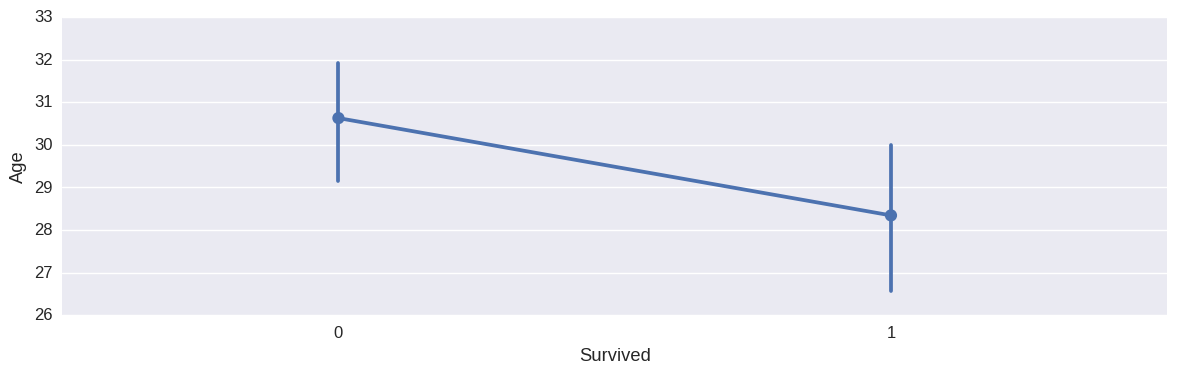

In [8]:
sb.factorplot(y='Age', x='Survived' ,data=dfTrain, aspect=3)

Age is clearly a factor, what about Fare?

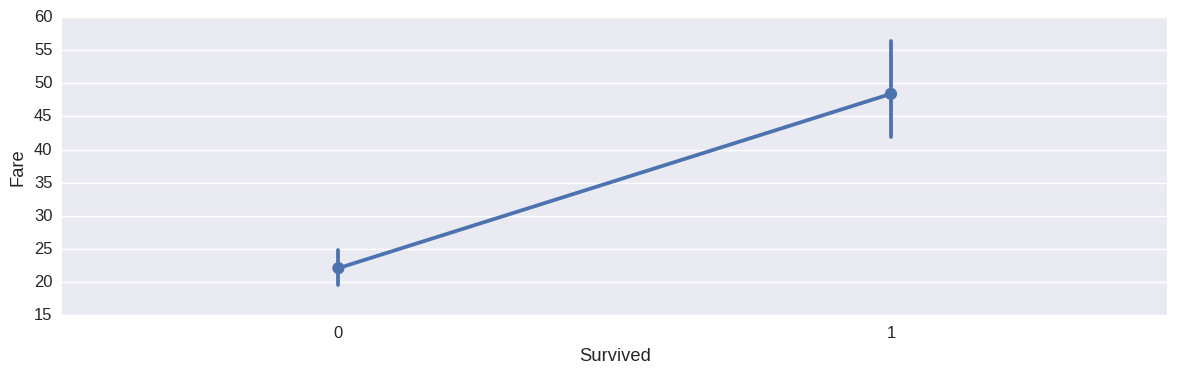

In [9]:
sb.factorplot(y='Fare', x='Survived', data=dfTrain, aspect=3);

Fare is clearly also a factor, but is it because it's a proxy for class?

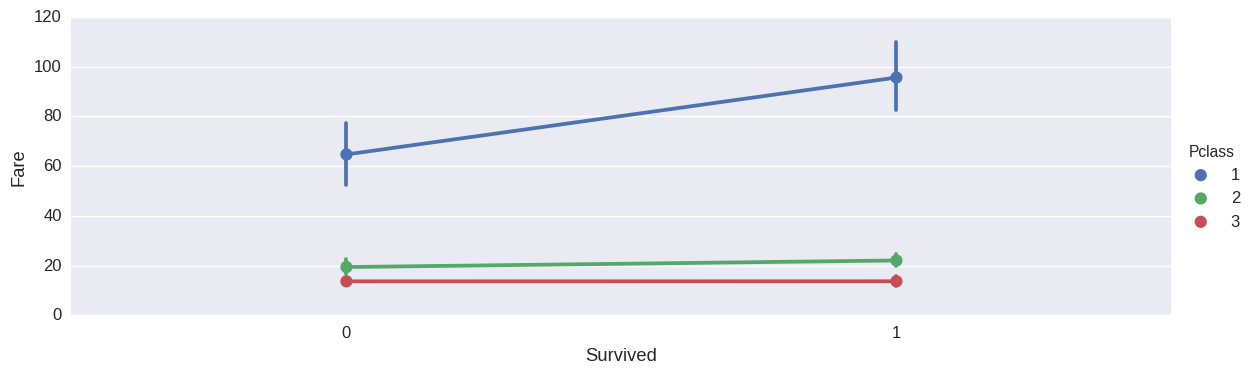

In [10]:
sb.factorplot(x='Survived', y='Fare', hue='Pclass', data=dfTrain, aspect=3);

Interestingly, Fare appears to have an effect in $1^{st}$ class only. Let's look at 'Embarked'.

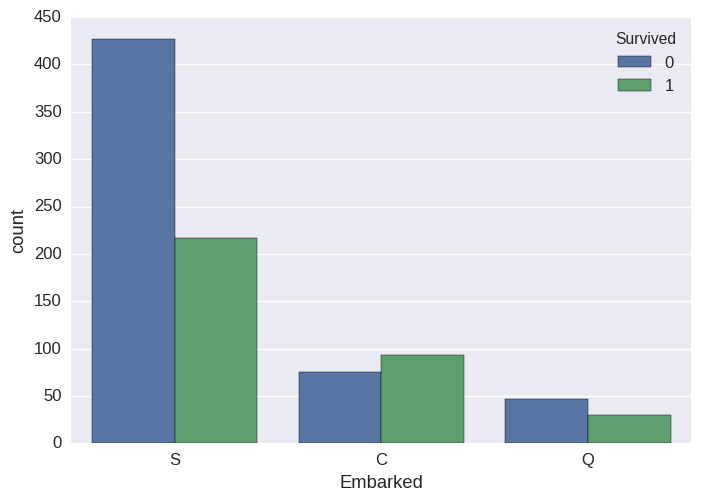

In [11]:
sb.countplot(x='Embarked', hue='Survived', data=dfTrain);

'Embarked', 'Age', and 'Fare' all seem to have an effect on survival so I'll clean up all three features. 

## Correcting spurrious entries and imputing missing data

First, since a lot of the transformation are common to both the training and the test set I'm going to combine both sets to ensure imputation does not drive a statistical wedge between the two sets. 

In [12]:
dfTemp = pd.concat((dfTrain,dfTest),join='inner')

In [13]:
print(dfTemp.describe())
print('-' * 50)
print(dfTemp.info())

            Pclass          Age        SibSp        Parch         Fare
count  1309.000000  1046.000000  1309.000000  1309.000000  1308.000000
mean      2.294882    29.881138     0.498854     0.385027    33.295479
std       0.837836    14.413493     1.041658     0.865560    51.758668
min       1.000000     0.170000     0.000000     0.000000     0.000000
25%       2.000000          NaN     0.000000     0.000000          NaN
50%       3.000000          NaN     0.000000     0.000000          NaN
75%       3.000000          NaN     1.000000     0.000000          NaN
max       3.000000    80.000000     8.000000     9.000000   512.329200
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Fare     

/home/madhatter106/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Now we're ready to do some imputation/corrections.
### Dealing with the "free" tickets in the training set:

In [14]:
dfTemp[dfTemp.Fare==0]

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
179,3,"Leonard, Mr. Lionel",male,36.0,0,0,0.0,S
263,1,"Harrison, Mr. William",male,40.0,0,0,0.0,S
271,3,"Tornquist, Mr. William Henry",male,25.0,0,0,0.0,S
277,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,0.0,S
302,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,0.0,S
413,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,0.0,S
466,2,"Campbell, Mr. William",male,NaN,0,0,0.0,S
481,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,0.0,S
597,3,"Johnson, Mr. Alfred",male,49.0,0,0,0.0,S
633,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,0.0,S


####  Some common details among "free ticket"  cases:
* embarked in Southampton
* SibSp = 0
* Parch = 0
* Sex = male
* Pclass = 1, 2, 3

It makes more sense to me to impute the class-dependent median fee of tickets bought in Southampton:

In [15]:
Fares_S_AllCl_Non0 = dfTemp.loc[(dfTemp.Fare != 0) & (dfTemp.Embarked == 'S'),['Pclass', 'Fare']]
for i in range(1,4):
    dfTrain.loc[(dfTrain.Fare == 0) & (dfTrain.Pclass == i),'Fare'] = Fares_S_AllCl_Non0[Fares_S_AllCl_Non0.Pclass == i].Fare.median()
    dfTest.loc[(dfTest.Fare == 0) & dfTest.Pclass == i, 'Fare'] = Fares_S_AllCl_Non0[Fares_S_AllCl_Non0.Pclass == i].Fare.median()

## Imputing missing values

### Imputing Embarked  
**Embarked** is only missing 2 entries, so I'd impute base on what's more common. But since the goal of this exercise is to be OCD:

In [16]:
dfTrain.loc[dfTrain.Embarked.isnull(),['Name','Fare', 'Pclass']]

,Name,Fare,Pclass
61,"Icard, Miss. Amelie",80.0,1
829,"Stone, Mrs. George Nelson (Martha Evelyn)",80.0,1


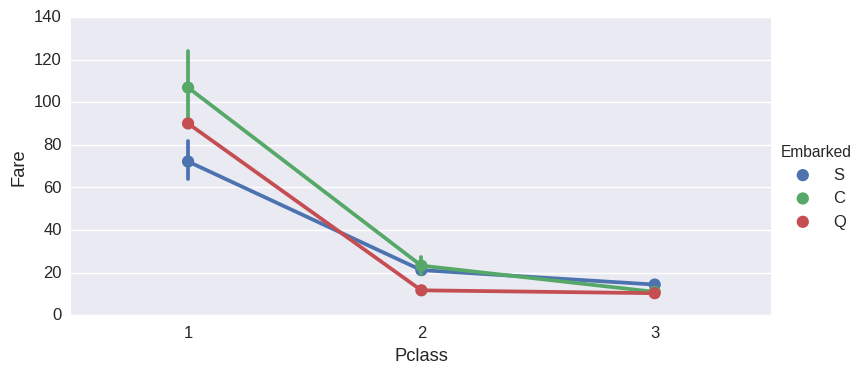

In [17]:
sb.factorplot(x='Pclass',y='Fare',hue='Embarked', data=dfTemp,aspect=2)

This suggests that 'S' is a relative safe bet. But I still wonder what the more frequent value in 'Embarked' is?

In [18]:
dfTrain['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Now I'm fairly confident 'S' is the right value to impute to 'Embarked'

In [19]:
dfTrain['Embarked'].fillna('S', inplace=True)

### Imputing Fare (in the test set)

Based on the factor plot above plotting fare against class, seems safe to correct bad Fare data based on Passenger Class.

In [20]:
pclass4fare = dfTest.loc[dfTest.Fare.isnull(), 'Pclass'].values[0]

In [21]:
msgClassMedianFare = dfTest[(dfTest.Pclass==pclass4fare)].Fare.dropna().median()

In [22]:
dfTest.loc[dfTest.Fare.isnull(),'Fare'] = msgClassMedianFare

### Imputing Age:  

Age is one of those things that to a first approximation can be estimated by how a person is referred to.
First I am going to catalogue titles present in names and create another feature, "Title". To do this I need to do an inventory of all possible titles present in the dataset. Titles seem to be the seconde word in the name string, ending with a '.'.

In [23]:
nameset = set()
cnt = 0
for name in dfTemp.Name.values:
    for subname in name.split(' '):
        # Now I grab the part that has a '.' after but verify it is an abbreviation, not an initial...
        if '.' in subname and len(subname) > 2:
            cnt += 1
            nameset.add(subname)

In [24]:
print(nameset)

{'Mr.', 'Mlle.', 'Miss.', 'Countess.', 'Dona.', 'Master.', 'Jonkheer.', 'Dr.', 'Ms.', 'Mrs.', 'Lady.', 'Major.', 'Col.', 'Capt.', 'Mme.', 'Rev.', 'Sir.', 'Don.'}


In [25]:
def createTitle(name):
    return list(set(name.split(' ')) & nameset)[0][:-1]

dfTrain['Title'] = dfTrain.Name.apply(createTitle)
dfTest['Title'] = dfTest.Name.apply(createTitle)
dfTemp['Title'] = dfTemp.Name.apply(createTitle)

Does title allow distinguishing age?

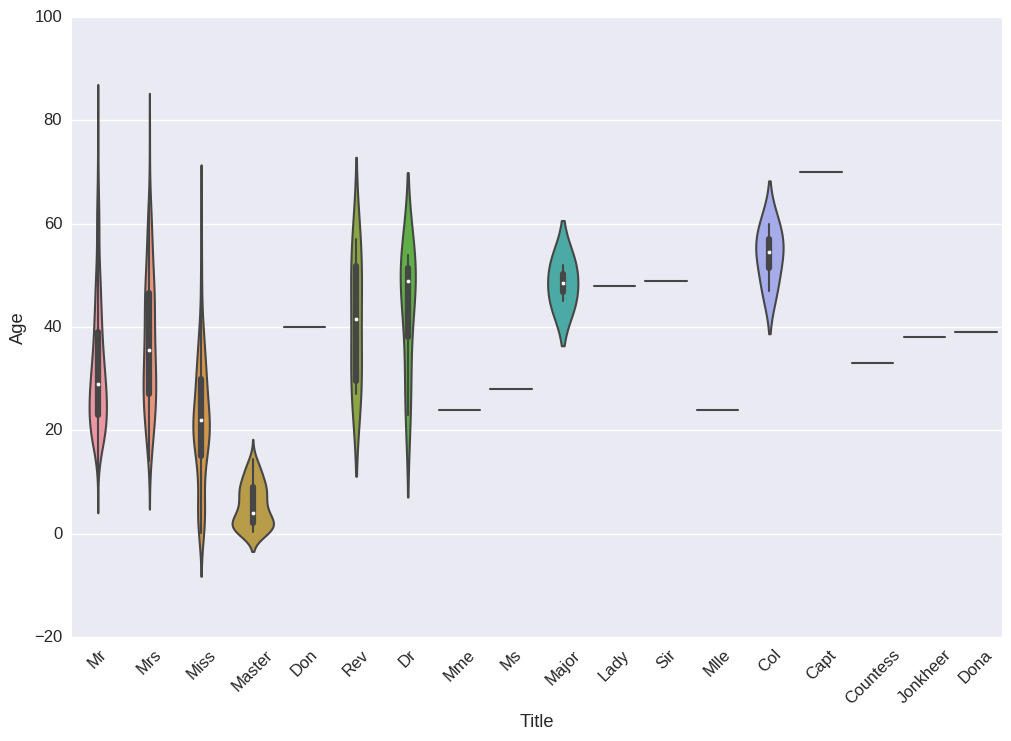

In [26]:
f = pl.figure(figsize=(12,8))
ax = f.add_subplot()
violin = sb.violinplot(x='Title',y='Age',data=dfTemp,ax=ax, scale='area')
for item in violin.get_xticklabels():
    item.set_rotation(45)

Not awesome. Still, some titles come with a wide age range; others, like Master have a markedly narrower range, and that could still be informative for my Age imputation. Also I probably don't need all titles. What titles do correspond to missing ages?

In [27]:
dfTemp.Title[dfTemp.Age.isnull()].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Dr', 'Ms'], dtype=object)

Clearly I don't need to use all of the 'Title' data. Based on the graph above, I will pack Ms and Miss together and impute missing age from the median Age of Miss. I will impute the remaining missing ages directly from the median Age of their corresponding category.

In [28]:
# re-titling Ms as Miss
dfTemp.loc[dfTemp.Title=='Ms', 'Title'] = 'Miss'

In [29]:
dfTrain.loc[(dfTrain.Age.isnull()) &
            ((dfTrain.Title=='Miss')|
             (dfTrain.Title=='Ms')),'Age'] = dfTemp.loc[dfTemp.Title=='Miss','Age'].median()
dfTest.loc[(dfTest.Age.isnull()) &
          ((dfTest.Title=='Miss')|
          (dfTest.Title=='Ms')),'Age'] = dfTemp.loc[dfTemp.Title=='Miss','Age'].median()

In [30]:
for title in ['Mr', 'Mrs','Master','Dr']:
    dfTrain.loc[(dfTrain.Age.isnull()) &
               (dfTrain.Title==title),'Age'] = dfTemp.loc[dfTemp.Title==title, 'Age'].median()
    dfTest.loc[(dfTest.Age.isnull()) &
              (dfTest.Title==title),'Age'] = dfTemp.loc[dfTemp.Title==title,'Age'].median()

In [31]:
print(dfTrain.info())
print('-' * 50)
print(dfTest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
Title       891 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Embarked    418 non-null object
Title       418 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 29.5+ KB
None

Now I can simplify this data set by dropping 'Title' and 'Name' data from both sets

In [32]:
dfTrain.drop(['Name','Title'],inplace=True, axis=1)
dfTest.drop(['Name','Title'], inplace=True,axis=1)

### Labeling categorical data

Sex, and Embarked are categorical variables that need to be relabeled numerically. Because neither feature is ordinal, I'm going to one-hot encode both, using pandas' get_dummies method. This will avoid introducing a "ranking" in these variables.

In [33]:
# one-hot encoding non-hierarchical categorical labels
dfTrain = pd.concat([dfTrain,pd.get_dummies(dfTrain[['Sex', 'Embarked']])],axis=1)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest[['Sex', 'Embarked',]])],axis=1)

Now we don't need 'Sex' or 'Embarked any more so we drop them from both sets

In [34]:
dfTrain.drop(['Sex', 'Embarked'], axis=1, inplace=True)
dfTest.drop(['Sex', 'Embarked'], axis=1, inplace=True)

This concludes this part of the pre-processing; the data cleanup.
Here's what the data sets look like

In [35]:
print(dfTrain.info())
print('-' * 50)
print(dfTest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Sex_female    891 non-null float64
Sex_male      891 non-null float64
Embarked_C    891 non-null float64
Embarked_Q    891 non-null float64
Embarked_S    891 non-null float64
dtypes: float64(7), int64(4)
memory usage: 76.6 KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
Pclass        418 non-null int64
Age           418 non-null float64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          418 non-null float64
Sex_female    418 non-null float64
Sex_male      418 non-null float64
Embarked_C    418 non-null float64
Embarked_Q    418 non-null float

I'm going to pickle both Dataframes for safekeeping until the next blog...

In [36]:
dfTrain.to_pickle('/home/madhatter106/DATA/Titanic/dfTrainCln_I.pkl')
dfTest.to_pickle('/home/madhatter106/DATA/Titanic/dfTestCln_I.pkl')

In the next notebook, I'll be looking to do some additional post-cleanup pre-processing. Until next time!